Demo to Rutvik Dhopate

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_csv = "/Users/hunjunsin/Desktop/Jun/Unsupervised/hw1/20news_train.csv"
test_csv = "/Users/hunjunsin/Desktop/Jun/Unsupervised/hw1/20news_test.csv"

train_data_news = pd.read_csv(train_csv)
test_data_news = pd.read_csv(test_csv)

news_data = pd.concat([train_data_news, test_data_news], ignore_index=True)

news_data = news_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"data number : {len(news_data)}")


data number : 18846


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

data_20 = news_data.dropna(subset = ['body']).reset_index(drop = True)
news_input = data_20['body'].reset_index(drop=True)
news_labels = data_20['label'].reset_index(drop=True)

vectorizer = TfidfVectorizer(
    max_features=1000, 
    lowercase=True, 
    stop_words="english", 
    max_df=0.8, 
    min_df=5
)
news_vectorize = vectorizer.fit_transform(news_input)

In [14]:
news_dense = news_vectorize.toarray()
print(news_dense.shape)
print(news_labels.shape)

(18817, 1000)
(18817,)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
news_dense_standardized = scaler.fit_transform(news_dense)

print(news_dense_standardized.shape)

(18817, 1000)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def compute_k_distance_cosine_chunk(X, k, batch_size=1000, normalize=True):

    n = len(X)
    
    if normalize:
        norms = np.linalg.norm(X, axis=1, keepdims=True)
        norms[norms == 0] = 1e-12
        X_norm = X / norms
    else:
        X_norm = X
    
    
    k_distances = np.zeros(n, dtype=float)

    print("Computing k-distance in chunks...")
    for start in tqdm(range(0, n, batch_size), desc="k-distance - chunk loop"):
        end = min(start + batch_size, n)

        X_chunk = X_norm[start:end]  
        
        chunk_similarity = X_chunk @ X_norm.T
        chunk_distance = 1.0 - chunk_similarity
        
        for i_local, row_distances in enumerate(chunk_distance):
            i_global = start + i_local
            
            kth_dist = np.partition(row_distances, k-1)[k-1]
            
    
            k_distances[i_global] = kth_dist
    
    return k_distances

def plot_k_distance(k_distances):

    k_distances_sorted = np.sort(k_distances)
    plt.figure(figsize=(6,4))
    plt.plot(k_distances_sorted)
    plt.xlabel("Points (sorted by distance)")
    plt.ylabel("k-distance (cosine)")
    plt.title("k-distance Graph")
    plt.grid(True)
    plt.show()

In [ ]:

from tqdm import tqdm

def dbscan_core_first_cosine_manual_batch(X, eps, min_pts, batch_size=1000):
    n = len(X)
    

    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1e-12
    X_norm = X / norms
    
    labels = np.zeros(n, dtype=int)
    visited = np.zeros(n, dtype=bool)
    is_core = np.zeros(n, dtype=bool)
    neighbors_list = [[] for _ in range(n)]
    
    for start in tqdm(range(0, n, batch_size), desc="Precomputing neighbors"):
        end = min(start + batch_size, n)
        X_chunk = X_norm[start:end]
        chunk_similarity = X_chunk @ X_norm.T
        chunk_distance = 1.0 - chunk_similarity
        
        for i_local, row_distances in enumerate(chunk_distance):
            i_global = start + i_local
            neighbor_indices = np.where(row_distances <= eps)[0]
            neighbors_list[i_global] = list(set(neighbor_indices.tolist()))
    
    for i in range(n):
        if len(neighbors_list[i]) >= min_pts:
            is_core[i] = True
        else:
            labels[i] = -1
    
    def expand_cluster_core(core_idx, cluster_id):
        labels[core_idx] = cluster_id
        seed_queue = set(neighbors_list[core_idx])
        while seed_queue:
            current_pt = seed_queue.pop()
            if not visited[current_pt]:
                visited[current_pt] = True
                if is_core[current_pt]:
                    seed_queue.update(neighbors_list[current_pt])
            if labels[current_pt] in [0, -1]:
                labels[current_pt] = cluster_id
    
    
    cluster_id = 0
    for i in tqdm(range(n), desc="Expanding clusters"):
        if is_core[i] and not visited[i]:
            cluster_id += 1
            visited[i] = True
            expand_cluster_core(i, cluster_id)
    
    return labels

K=3

Computing k-distance in chunks...


k-distance - chunk loop: 100%|██████████| 19/19 [00:14<00:00,  1.33it/s]


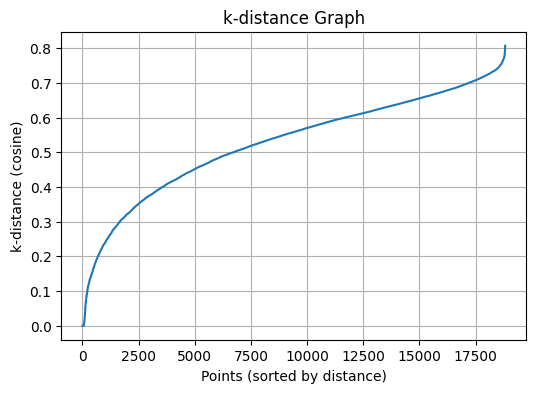

In [27]:
distance_matrix = compute_k_distance_cosine_chunk(news_dense_standardized, k=3, batch_size=1000)
plot_k_distance(distance_matrix)

test eps with 0.025 0.05 0.1 0.2 0.3 

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

eps_candidates = [0.025, 0.05 ,0.1, 0.2, 0.3]

for eps_val in eps_candidates:
    print(f"\n=== DBSCAN with eps={eps_val} ===")
    labels = dbscan_core_first_cosine_manual_batch(
        news_dense_standardized,  
        eps=eps_val,
        min_pts=3,
        batch_size=1000
    )
    
    print("DBSCAN Finished.")
    unique_labels = np.unique(labels)
    unique_valid_labels, valid_counts = np.unique(labels, return_counts=True)

    print("\n=== Cluster counts (excluding noise/unassigned) ===")
    for cluster_id, count in zip(unique_valid_labels, valid_counts):
        print(f"Cluster {cluster_id}: {count} points")
    

    mask = (labels != -1) & (labels != 0)
    valid_labels = labels[mask]
    
    n_clusters = len(set(valid_labels))
    print("Number of clusters (excluding noise & 0):", n_clusters)
    
    if n_clusters >= 2:
        
        X_valid = news_dense_standardized[mask]
        sil_score = silhouette_score(X_valid, valid_labels)
        print(f"Silhouette score (eps={eps_val}): {sil_score:.4f}")
    else:
        print("Not enough clusters to compute a Silhouette score.")


=== DBSCAN with eps=0.025 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 1599145.32it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 18699 points
Cluster 1: 5 points
Cluster 2: 4 points
Cluster 3: 3 points
Cluster 4: 4 points
Cluster 5: 25 points
Cluster 6: 3 points
Cluster 7: 5 points
Cluster 8: 3 points
Cluster 9: 3 points
Cluster 10: 3 points
Cluster 11: 4 points
Cluster 12: 3 points
Cluster 13: 3 points
Cluster 14: 3 points
Cluster 15: 6 points
Cluster 16: 3 points
Cluster 17: 4 points
Cluster 18: 3 points
Cluster 19: 3 points
Cluster 20: 5 points
Cluster 21: 3 points
Cluster 22: 3 points
Cluster 23: 3 points
Cluster 24: 4 points
Cluster 25: 3 points
Cluster 26: 3 points
Cluster 27: 4 points
Number of clusters (excluding noise & 0): 27
Silhouette score (eps=0.025): 0.9266

=== DBSCAN with eps=0.05 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 1163782.21it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 18680 points
Cluster 1: 5 points
Cluster 2: 6 points
Cluster 3: 4 points
Cluster 4: 3 points
Cluster 5: 4 points
Cluster 6: 25 points
Cluster 7: 3 points
Cluster 8: 6 points
Cluster 9: 5 points
Cluster 10: 3 points
Cluster 11: 3 points
Cluster 12: 3 points
Cluster 13: 3 points
Cluster 14: 4 points
Cluster 15: 3 points
Cluster 16: 3 points
Cluster 17: 6 points
Cluster 18: 3 points
Cluster 19: 4 points
Cluster 20: 4 points
Cluster 21: 3 points
Cluster 22: 3 points
Cluster 23: 3 points
Cluster 24: 5 points
Cluster 25: 3 points
Cluster 26: 3 points
Cluster 27: 4 points
Cluster 28: 3 points
Cluster 29: 4 points
Cluster 30: 3 points
Cluster 31: 3 points
Number of clusters (excluding noise & 0): 31
Silhouette score (eps=0.05): 0.8865

=== DBSCAN with eps=0.1 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 1606109.45it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 18556 points
Cluster 1: 6 points
Cluster 2: 3 points
Cluster 3: 7 points
Cluster 4: 3 points
Cluster 5: 3 points
Cluster 6: 4 points
Cluster 7: 3 points
Cluster 8: 3 points
Cluster 9: 3 points
Cluster 10: 4 points
Cluster 11: 25 points
Cluster 12: 3 points
Cluster 13: 6 points
Cluster 14: 4 points
Cluster 15: 3 points
Cluster 16: 6 points
Cluster 17: 3 points
Cluster 18: 5 points
Cluster 19: 3 points
Cluster 20: 7 points
Cluster 21: 3 points
Cluster 22: 5 points
Cluster 23: 3 points
Cluster 24: 3 points
Cluster 25: 4 points
Cluster 26: 3 points
Cluster 27: 3 points
Cluster 28: 4 points
Cluster 29: 3 points
Cluster 30: 4 points
Cluster 31: 3 points
Cluster 32: 3 points
Cluster 33: 3 points
Cluster 34: 6 points
Cluster 35: 8 points
Cluster 36: 3 points
Cluster 37: 4 points
Cluster 38: 3 points
Cluster 39: 5 points
Cluster 40: 3 points
Cluster 41: 3 points
Cluster 42: 3 points
Cluster 43: 3 points
Cluster 44

Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 1119794.25it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 17911 points
Cluster 1: 8 points
Cluster 2: 4 points
Cluster 3: 3 points
Cluster 4: 7 points
Cluster 5: 7 points
Cluster 6: 9 points
Cluster 7: 3 points
Cluster 8: 5 points
Cluster 9: 3 points
Cluster 10: 4 points
Cluster 11: 8 points
Cluster 12: 4 points
Cluster 13: 6 points
Cluster 14: 3 points
Cluster 15: 3 points
Cluster 16: 5 points
Cluster 17: 5 points
Cluster 18: 12 points
Cluster 19: 3 points
Cluster 20: 8 points
Cluster 21: 4 points
Cluster 22: 25 points
Cluster 23: 3 points
Cluster 24: 3 points
Cluster 25: 4 points
Cluster 26: 3 points
Cluster 27: 3 points
Cluster 28: 3 points
Cluster 29: 3 points
Cluster 30: 3 points
Cluster 31: 6 points
Cluster 32: 3 points
Cluster 33: 4 points
Cluster 34: 3 points
Cluster 35: 3 points
Cluster 36: 4 points
Cluster 37: 3 points
Cluster 38: 7 points
Cluster 39: 5 points
Cluster 40: 3 points
Cluster 41: 3 points
Cluster 42: 4 points
Cluster 43: 3 points
Cluster 4

Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 865824.35it/s]

DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 16551 points
Cluster 1: 4 points
Cluster 2: 6 points
Cluster 3: 8 points
Cluster 4: 5 points
Cluster 5: 4 points
Cluster 6: 3 points
Cluster 7: 3 points
Cluster 8: 4 points
Cluster 9: 7 points
Cluster 10: 5 points
Cluster 11: 3 points
Cluster 12: 6 points
Cluster 13: 9 points
Cluster 14: 10 points
Cluster 15: 3 points
Cluster 16: 8 points
Cluster 17: 3 points
Cluster 18: 4 points
Cluster 19: 3 points
Cluster 20: 3 points
Cluster 21: 5 points
Cluster 22: 16 points
Cluster 23: 3 points
Cluster 24: 3 points
Cluster 25: 4 points
Cluster 26: 4 points
Cluster 27: 9 points
Cluster 28: 27 points
Cluster 29: 5 points
Cluster 30: 6 points
Cluster 31: 3 points
Cluster 32: 3 points
Cluster 33: 8 points
Cluster 34: 4 points
Cluster 35: 10 points
Cluster 36: 7 points
Cluster 37: 3 points
Cluster 38: 8 points
Cluster 39: 28 points
Cluster 40: 3 points
Cluster 41: 3 points
Cluster 42: 3 points
Cluster 43: 5 points
Cluste

K=5

Computing k-distance in chunks...


k-distance - chunk loop: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]


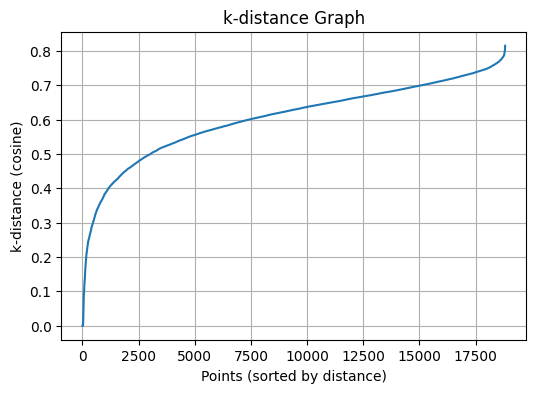

In [41]:
distance_matrix = compute_k_distance_cosine_chunk(news_dense_standardized, k=5, batch_size=1000)
plot_k_distance(distance_matrix)

test epsilon with 0.2 0.3 0.4 0.5 0.6

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

eps_candidates = [0.2, 0.3, 0.4 ,0.5 ,0.6, 0.7]

for eps_val in eps_candidates:
    print(f"\n=== DBSCAN with eps={eps_val} ===")
    labels = dbscan_core_first_cosine_manual_batch(
        news_dense_standardized,  # 입력 데이터
        eps=eps_val,
        min_pts=5,
        batch_size=1000
    )
    
    print("DBSCAN Finished.")
    unique_labels = np.unique(labels)

    mask = (labels != -1) & (labels != 0)
    valid_labels = labels[mask]
    
    n_clusters = len(set(valid_labels))
    print("Number of clusters (excluding noise & 0):", n_clusters)
    
    unique_labels = np.unique(labels)
    unique_valid_labels, valid_counts = np.unique(labels, return_counts=True)

    print("\n=== Cluster counts (excluding noise/unassigned) ===")
    for cluster_id, count in zip(unique_valid_labels, valid_counts):
        print(f"Cluster {cluster_id}: {count} points")
    
    if n_clusters >= 2:
        X_valid = news_dense_standardized[mask]
        sil_score = silhouette_score(X_valid, valid_labels)
        print(f"Silhouette score (eps={eps_val}): {sil_score:.4f}")
    else:
        print("Not enough clusters to compute a Silhouette score.")


=== DBSCAN with eps=0.2 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 1347726.62it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 34

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 18568 points
Cluster 1: 8 points
Cluster 2: 7 points
Cluster 3: 9 points
Cluster 4: 8 points
Cluster 5: 6 points
Cluster 6: 5 points
Cluster 7: 10 points
Cluster 8: 8 points
Cluster 9: 25 points
Cluster 10: 6 points
Cluster 11: 7 points
Cluster 12: 7 points
Cluster 13: 5 points
Cluster 14: 8 points
Cluster 15: 7 points
Cluster 16: 6 points
Cluster 17: 7 points
Cluster 18: 11 points
Cluster 19: 6 points
Cluster 20: 5 points
Cluster 21: 6 points
Cluster 22: 9 points
Cluster 23: 11 points
Cluster 24: 5 points
Cluster 25: 5 points
Cluster 26: 5 points
Cluster 27: 7 points
Cluster 28: 7 points
Cluster 29: 6 points
Cluster 30: 6 points
Cluster 31: 5 points
Cluster 32: 6 points
Cluster 33: 5 points
Cluster 34: 5 points
Silhouette score (eps=0.2): 0.5359

=== DBSCAN with eps=0.3 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 1270287.27it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 95

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 18043 points
Cluster 1: 6 points
Cluster 2: 8 points
Cluster 3: 5 points
Cluster 4: 7 points
Cluster 5: 9 points
Cluster 6: 10 points
Cluster 7: 8 points
Cluster 8: 14 points
Cluster 9: 9 points
Cluster 10: 27 points
Cluster 11: 6 points
Cluster 12: 8 points
Cluster 13: 10 points
Cluster 14: 7 points
Cluster 15: 7 points
Cluster 16: 25 points
Cluster 17: 9 points
Cluster 18: 15 points
Cluster 19: 25 points
Cluster 20: 8 points
Cluster 21: 5 points
Cluster 22: 7 points
Cluster 23: 9 points
Cluster 24: 6 points
Cluster 25: 9 points
Cluster 26: 48 points
Cluster 27: 12 points
Cluster 28: 5 points
Cluster 29: 5 points
Cluster 30: 5 points
Cluster 31: 8 points
Cluster 32: 5 points
Cluster 33: 12 points
Cluster 34: 5 points
Cluster 35: 8 points
Cluster 36: 8 points
Cluster 37: 15 points
Cluster 38: 9 points
Cluster 39: 6 points
Cluster 40: 6 points
Cluster 41: 10 poi

Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 2070795.22it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 215

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 16681 points
Cluster 1: 15 points
Cluster 2: 9 points
Cluster 3: 44 points
Cluster 4: 11 points
Cluster 5: 7 points
Cluster 6: 5 points
Cluster 7: 21 points
Cluster 8: 12 points
Cluster 9: 24 points
Cluster 10: 17 points
Cluster 11: 6 points
Cluster 12: 151 points
Cluster 13: 44 points
Cluster 14: 76 points
Cluster 15: 13 points
Cluster 16: 5 points
Cluster 17: 6 points
Cluster 18: 5 points
Cluster 19: 5 points
Cluster 20: 11 points
Cluster 21: 8 points
Cluster 22: 11 points
Cluster 23: 12 points
Cluster 24: 25 points
Cluster 25: 15 points
Cluster 26: 10 points
Cluster 27: 25 points
Cluster 28: 6 points
Cluster 29: 19 points
Cluster 30: 5 points
Cluster 31: 12 points
Cluster 32: 8 points
Cluster 33: 18 points
Cluster 34: 10 points
Cluster 35: 14 points
Cluster 36: 8 points
Cluster 37: 33 points
Cluster 38: 37 points
Cluster 39: 7 points
Cluster 40: 14 points
C

Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 997929.12it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 343

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 13150 points
Cluster 1: 12 points
Cluster 2: 1427 points
Cluster 3: 332 points
Cluster 4: 76 points
Cluster 5: 65 points
Cluster 6: 7 points
Cluster 7: 27 points
Cluster 8: 48 points
Cluster 9: 5 points
Cluster 10: 146 points
Cluster 11: 15 points
Cluster 12: 5 points
Cluster 13: 10 points
Cluster 14: 62 points
Cluster 15: 15 points
Cluster 16: 9 points
Cluster 17: 9 points
Cluster 18: 36 points
Cluster 19: 14 points
Cluster 20: 34 points
Cluster 21: 7 points
Cluster 22: 12 points
Cluster 23: 52 points
Cluster 24: 9 points
Cluster 25: 21 points
Cluster 26: 13 points
Cluster 27: 7 points
Cluster 28: 6 points
Cluster 29: 13 points
Cluster 30: 5 points
Cluster 31: 36 points
Cluster 32: 8 points
Cluster 33: 8 points
Cluster 34: 30 points
Cluster 35: 5 points
Cluster 36: 19 points
Cluster 37: 48 points
Cluster 38: 22 points
Cluster 39: 6 points
Cluster 40: 45 point

Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 882229.13it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 95

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 6723 points
Cluster 1: 11479 points
Cluster 2: 7 points
Cluster 3: 11 points
Cluster 4: 10 points
Cluster 5: 11 points
Cluster 6: 6 points
Cluster 7: 5 points
Cluster 8: 9 points
Cluster 9: 9 points
Cluster 10: 5 points
Cluster 11: 8 points
Cluster 12: 25 points
Cluster 13: 5 points
Cluster 14: 9 points
Cluster 15: 5 points
Cluster 16: 13 points
Cluster 17: 6 points
Cluster 18: 8 points
Cluster 19: 11 points
Cluster 20: 8 points
Cluster 21: 7 points
Cluster 22: 4 points
Cluster 23: 6 points
Cluster 24: 6 points
Cluster 25: 7 points
Cluster 26: 18 points
Cluster 27: 6 points
Cluster 28: 4 points
Cluster 29: 8 points
Cluster 30: 6 points
Cluster 31: 5 points
Cluster 32: 6 points
Cluster 33: 9 points
Cluster 34: 4 points
Cluster 35: 12 points
Cluster 36: 12 points
Cluster 37: 6 points
Cluster 38: 5 points
Cluster 39: 12 points
Cluster 40: 13 points
Cluster 41: 6 p

Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 433071.33it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 3

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 966 points
Cluster 1: 17822 points
Cluster 2: 25 points
Cluster 3: 4 points
Silhouette score (eps=0.7): -0.2860


K=10

Computing k-distance in chunks...


k-distance - chunk loop: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s]


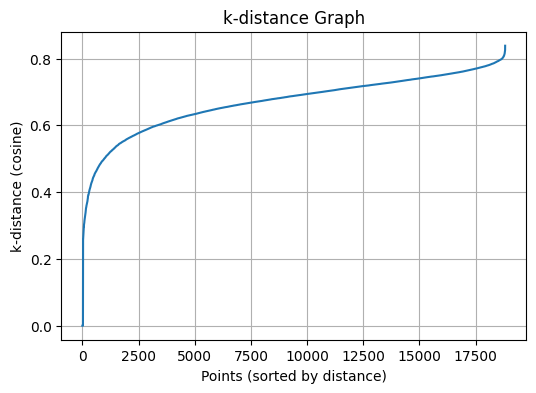

In [16]:
distance_matrix = compute_k_distance_cosine_chunk(news_dense_standardized, k=10, batch_size=1000)
plot_k_distance(distance_matrix)

test epsilon with 0.2 0.3 0.4 0.5 0.6

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

eps_candidates = [0.2, 0.3, 0.4, 0.5, 0.6]

for eps_val in eps_candidates:
    print(f"\n=== DBSCAN with eps={eps_val} ===")
    labels = dbscan_core_first_cosine_manual_batch(
        news_dense_standardized,  # 입력 데이터
        eps=eps_val,
        min_pts=10,
        batch_size=1000
    )
    
    print("DBSCAN Finished.")
    unique_labels = np.unique(labels)
    mask = (labels != -1) & (labels != 0)
    valid_labels = labels[mask]
    
    n_clusters = len(set(valid_labels))
    print("Number of clusters (excluding noise & 0):", n_clusters)
    
    if n_clusters >= 2:

        X_valid = news_dense_standardized[mask]
        sil_score = silhouette_score(X_valid, valid_labels)
        print(f"Silhouette score (eps={eps_val}): {sil_score:.4f}")
    else:
        print("Not enough clusters to compute a Silhouette score.")


=== DBSCAN with eps=0.2 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 2498946.22it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 1
Not enough clusters to compute a Silhouette score.

=== DBSCAN with eps=0.3 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 1079217.00it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 12
Silhouette score (eps=0.3): 0.3004

=== DBSCAN with eps=0.4 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 305296.05it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 36
Silhouette score (eps=0.4): 0.0761

=== DBSCAN with eps=0.5 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 1094573.45it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 104
Silhouette score (eps=0.5): -0.0957

=== DBSCAN with eps=0.6 ===


Expanding clusters: 100%|██████████| 18817/18817 [00:00<00:00, 81363.50it/s]


DBSCAN Finished.
Number of clusters (excluding noise & 0): 75
Silhouette score (eps=0.6): -0.2658


Extra Credit

In [1]:
import numpy as np
from tqdm import tqdm

def filter_ambiguous_points(X, ground_truth_labels, eps, similarity_threshold=0.6, batch_size=1000):
    n = len(X)
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0] = 1e-12
    X_norm = X / norms
    neighbors_list = [[] for _ in range(n)]
    
    for start in tqdm(range(0, n, batch_size), desc="Precomputing neighbors for filtering"):
        end = min(start + batch_size, n)
        X_chunk = X_norm[start:end]
        chunk_similarity = X_chunk @ X_norm.T
        chunk_distance = 1.0 - chunk_similarity
        
        for i_local, row_distances in enumerate(chunk_distance):
            i_global = start + i_local
            neighbor_indices = np.where(row_distances <= eps)[0]
            neighbors_list[i_global] = list(set(neighbor_indices.tolist()))
    
    keep_indices = []

    for i in tqdm(range(n), desc="Filtering ambiguous points"):
        neighbors = neighbors_list[i]
        
        if len(neighbors) == 0:
            keep_indices.append(i)
            continue
        
        same_label_count = sum(ground_truth_labels[j] == ground_truth_labels[i] for j in neighbors)
        ratio = same_label_count / len(neighbors)
        
        if ratio >= similarity_threshold:
            keep_indices.append(i)
    
    return keep_indices


In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score

eps_candidates = [0.2, 0.3, 0.4, 0.5, 0.6]

for eps_val in eps_candidates:
    print(f"\n=== DBSCAN with eps={eps_val} ===")
    
    filtered_indices = filter_ambiguous_points(news_dense_standardized, news_labels.values, eps=eps_val, similarity_threshold=0.8)
    X_curated = news_dense_standardized[filtered_indices]
    ground_truth_curated = news_labels.iloc[filtered_indices].reset_index(drop=True)
    
    labels = dbscan_core_first_cosine_manual_batch(
        X_curated, 
        eps=eps_val,
        min_pts=5,
        batch_size=1000
    )
    
    print("DBSCAN Finished.")
    
    
    unique_labels = np.unique(labels)
    unique_valid_labels, valid_counts = np.unique(labels, return_counts=True)

    print("\n=== Cluster counts (excluding noise/unassigned) ===")
    for cluster_id, count in zip(unique_valid_labels, valid_counts):
        print(f"Cluster {cluster_id}: {count} points")
    

    mask = (labels != -1) & (labels != 0)
    valid_labels = labels[mask]
    
    n_clusters = len(set(valid_labels))
    print("Number of clusters (excluding noise & 0):", n_clusters)
    
    if n_clusters >= 2:
        
        X_valid = X_curated[mask]
        sil_score = silhouette_score(X_valid, valid_labels)
        print(f"Silhouette score (eps={eps_val}): {sil_score:.4f}")
    else:
        print("Not enough clusters to compute a Silhouette score.")


=== DBSCAN with eps=0.2 ===


Expanding clusters: 100%|██████████| 18656/18656 [00:00<00:00, 1235262.45it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 18450 points
Cluster 1: 8 points
Cluster 2: 7 points
Cluster 3: 9 points
Cluster 4: 8 points
Cluster 5: 6 points
Cluster 6: 5 points
Cluster 7: 10 points
Cluster 8: 8 points
Cluster 9: 6 points
Cluster 10: 7 points
Cluster 11: 7 points
Cluster 12: 5 points
Cluster 13: 8 points
Cluster 14: 6 points
Cluster 15: 7 points
Cluster 16: 6 points
Cluster 17: 5 points
Cluster 18: 6 points
Cluster 19: 9 points
Cluster 20: 11 points
Cluster 21: 5 points
Cluster 22: 5 points
Cluster 23: 5 points
Cluster 24: 7 points
Cluster 25: 7 points
Cluster 26: 6 points
Cluster 27: 6 points
Cluster 28: 5 points
Cluster 29: 6 points
Cluster 30: 5 points
Cluster 31: 5 points
Number of clusters (excluding noise & 0): 31
Silhouette score (eps=0.2): 0.5680

=== DBSCAN with eps=0.3 ===


Expanding clusters: 100%|██████████| 18492/18492 [00:00<00:00, 2514542.70it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 17857 points
Cluster 1: 6 points
Cluster 2: 8 points
Cluster 3: 7 points
Cluster 4: 9 points
Cluster 5: 10 points
Cluster 6: 7 points
Cluster 7: 14 points
Cluster 8: 9 points
Cluster 9: 25 points
Cluster 10: 6 points
Cluster 11: 7 points
Cluster 12: 10 points
Cluster 13: 7 points
Cluster 14: 25 points
Cluster 15: 9 points
Cluster 16: 15 points
Cluster 17: 7 points
Cluster 18: 7 points
Cluster 19: 9 points
Cluster 20: 6 points
Cluster 21: 48 points
Cluster 22: 12 points
Cluster 23: 5 points
Cluster 24: 5 points
Cluster 25: 7 points
Cluster 26: 5 points
Cluster 27: 10 points
Cluster 28: 5 points
Cluster 29: 8 points
Cluster 30: 14 points
Cluster 31: 9 points
Cluster 32: 6 points
Cluster 33: 10 points
Cluster 34: 6 points
Cluster 35: 7 points
Cluster 36: 7 points
Cluster 37: 5 points
Cluster 38: 6 points
Cluster 39: 5 points
Cluster 40: 12 points
Cluster 41: 9 points
Cluster 42: 6 points
Cluster 43: 7 points

Expanding clusters: 100%|██████████| 17820/17820 [00:00<00:00, 913945.92it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 16436 points
Cluster 1: 6 points
Cluster 2: 9 points
Cluster 3: 7 points
Cluster 4: 5 points
Cluster 5: 19 points
Cluster 6: 20 points
Cluster 7: 15 points
Cluster 8: 149 points
Cluster 9: 29 points
Cluster 10: 13 points
Cluster 11: 28 points
Cluster 12: 5 points
Cluster 13: 6 points
Cluster 14: 5 points
Cluster 15: 5 points
Cluster 16: 11 points
Cluster 17: 70 points
Cluster 18: 12 points
Cluster 19: 14 points
Cluster 20: 10 points
Cluster 21: 18 points
Cluster 22: 7 points
Cluster 23: 18 points
Cluster 24: 7 points
Cluster 25: 8 points
Cluster 26: 11 points
Cluster 27: 7 points
Cluster 28: 11 points
Cluster 29: 5 points
Cluster 30: 14 points
Cluster 31: 13 points
Cluster 32: 9 points
Cluster 33: 6 points
Cluster 34: 5 points
Cluster 35: 11 points
Cluster 36: 7 points
Cluster 37: 8 points
Cluster 38: 20 points
Cluster 39: 10 points
Cluster 40: 8 points
Cluster 41: 10 points
Cluster 42: 14 points
Cluster 

Expanding clusters: 100%|██████████| 16090/16090 [00:00<00:00, 1313679.66it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 13430 points
Cluster 1: 30 points
Cluster 2: 5 points
Cluster 3: 8 points
Cluster 4: 5 points
Cluster 5: 53 points
Cluster 6: 9 points
Cluster 7: 8 points
Cluster 8: 8 points
Cluster 9: 38 points
Cluster 10: 7 points
Cluster 11: 9 points
Cluster 12: 191 points
Cluster 13: 13 points
Cluster 14: 40 points
Cluster 15: 6 points
Cluster 16: 5 points
Cluster 17: 52 points
Cluster 18: 5 points
Cluster 19: 12 points
Cluster 20: 5 points
Cluster 21: 8 points
Cluster 22: 120 points
Cluster 23: 8 points
Cluster 24: 9 points
Cluster 25: 42 points
Cluster 26: 5 points
Cluster 27: 5 points
Cluster 28: 5 points
Cluster 29: 13 points
Cluster 30: 19 points
Cluster 31: 6 points
Cluster 32: 6 points
Cluster 33: 9 points
Cluster 34: 11 points
Cluster 35: 12 points
Cluster 36: 11 points
Cluster 37: 7 points
Cluster 38: 6 points
Cluster 39: 16 points
Cluster 40: 4 points
Cluster 41: 16 points
Cluster 42: 25 points
Cluster 43: 

Expanding clusters: 100%|██████████| 12146/12146 [00:00<00:00, 387209.68it/s]


DBSCAN Finished.

=== Cluster counts (excluding noise/unassigned) ===
Cluster -1: 8282 points
Cluster 1: 147 points
Cluster 2: 643 points
Cluster 3: 440 points
Cluster 4: 169 points
Cluster 5: 120 points
Cluster 6: 28 points
Cluster 7: 8 points
Cluster 8: 6 points
Cluster 9: 10 points
Cluster 10: 10 points
Cluster 11: 19 points
Cluster 12: 106 points
Cluster 13: 11 points
Cluster 14: 6 points
Cluster 15: 35 points
Cluster 16: 9 points
Cluster 17: 5 points
Cluster 18: 14 points
Cluster 19: 102 points
Cluster 20: 7 points
Cluster 21: 6 points
Cluster 22: 5 points
Cluster 23: 17 points
Cluster 24: 64 points
Cluster 25: 6 points
Cluster 26: 5 points
Cluster 27: 6 points
Cluster 28: 79 points
Cluster 29: 14 points
Cluster 30: 5 points
Cluster 31: 5 points
Cluster 32: 7 points
Cluster 33: 85 points
Cluster 34: 7 points
Cluster 35: 16 points
Cluster 36: 8 points
Cluster 37: 6 points
Cluster 38: 96 points
Cluster 39: 69 points
Cluster 40: 64 points
Cluster 41: 26 points
Cluster 42: 5 points
Cl